# Training a Plant Disease Diagnosis Model with PlantVillage Dataset

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('default')
from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import keras
import keras.backend as K
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.utils.data_utils import get_file

from keras import layers
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.model_selection import train_test_split

# Persiapan

## Pengambilan Data

In [5]:
# Akses dataset
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"chaerurachmadiputra","key":"7b316b8a5925cb8e6cff1191bee7bb5d"}

import json

with open('/home/wsuser/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /home/wsuser/.kaggle/kaggle.json

In [6]:
!pip install kaggle
import kaggle

!kaggle datasets download -d chaerurachmadiputra/tomatkuu --unzip chaerurachmadiputra/tomatkuu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 11.7 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.15-py3-none-any.whl size=99620 sha256=a32acb24acef02f2dcd9bda5e736bb0efad13e045a56543492ea707619c703dc
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/46/0f/33/40c049c224ee941c2b3a7abb858fc34d93e827f9a833d40f09
Successfully built kaggle
 91%|█████████████████████████████████████▏   | 161M/177M [00:01<00:00, 134MB/s]
100%|█████████████████████████████████████████| 177M/177M [00:01<00:00, 119MB/s]


In [8]:
#folder structure
!ls tomato

Tomato_Bacterial_Spot  Tomato_Leaf_Mold		  Tomato_Target_Spot
Tomato_Early_Blight    Tomato_Mosaic_Virus	  Tomato_Yellow_Leaf_Curl_Virus
Tomato_Healthy	       Tomato_Septoria_Leaf_Spot
Tomato_Late_Blight     Tomato_Spider_Mites


Tomato_Septoria_Leaf_Spot


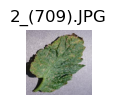

Tomato_Late_Blight


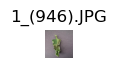

Tomato_Spider_Mites


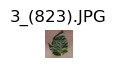

Tomato_Leaf_Mold


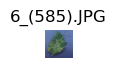

Tomato_Healthy


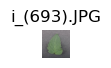

Tomato_Yellow_Leaf_Curl_Virus


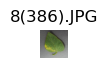

Tomato_Mosaic_Virus


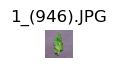

Tomato_Early_Blight


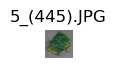

Tomato_Bacterial_Spot


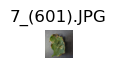

Tomato_Target_Spot


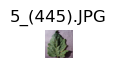

In [11]:
plt.figure(figsize=(15,10))

#visualize several images

parent_directory = "tomato"

for i, folder in enumerate(os.listdir(parent_directory)):
    print(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    file = files[0]
    file_path = os.path.join(folder_directory,file)

    image = imread(file_path)
    plt.subplot(1,15,i+1)
    plt.imshow(image)
    plt.axis("off")

    name = file
    plt.title(name)
    plt.show()

In [12]:
#load everything into memory
x = []
y = []
class_names = []
parent_directory = "tomato"

for i,folder in enumerate(os.listdir(parent_directory)):
    print(i,folder)
    class_names.append(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    for file in files:
        file_path = os.path.join(folder_directory,file)
        image = load_img(file_path,target_size=(64,64))
        image = img_to_array(image)/255.
        x.append(image)
        y.append(i)

x = np.array(x)
y = to_categorical(y)

0 Tomato_Septoria_Leaf_Spot
1 Tomato_Late_Blight
2 Tomato_Spider_Mites
3 Tomato_Leaf_Mold
4 Tomato_Healthy
5 Tomato_Yellow_Leaf_Curl_Virus
6 Tomato_Mosaic_Virus
7 Tomato_Early_Blight
8 Tomato_Bacterial_Spot
9 Tomato_Target_Spot


In [13]:
#check the data shape
print(x.shape)
print(y.shape)
print(y[0])

(11000, 64, 64, 3)
(11000, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
x_train, _x, y_train, _y = train_test_split(x,y,test_size=0.2, stratify = y, random_state = 1)
x_valid,x_test, y_valid, y_test = train_test_split(_x,_y,test_size=0.4, stratify = _y, random_state = 1)

print("train data:",x_train.shape,y_train.shape)
print("validation data:",x_valid.shape,y_valid.shape)
print("test data:",x_test.shape,y_test.shape)


train data: (8800, 64, 64, 3) (8800, 10)
validation data: (1320, 64, 64, 3) (1320, 10)
test data: (880, 64, 64, 3) (880, 10)


In [15]:
import tensorflow as tf
IMG_SHAPE = (64, 64, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

2023-07-04 12:43:36.470864: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


17225924/17225924 [==============================] - 0s 0us/step


In [16]:
base_model.trainable = True
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 4, 4, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 4, 4, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 4, 4, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 4, 4, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 4, 4, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 4, 4, 512)         262144    
                                                                 
 conv_pw_9

## Model Preparation

In [24]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 2, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 32)          131104    
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 3,360,298
Trainable params: 3,338,410
Non-trainable params: 21,888
_________________________________________________________________


## Training

In [25]:
#utilize early stopping function to stop at the lowest validation loss
#es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
#utilize save best weight model during training
ckpt = ModelCheckpoint("DeteksiPenyakitTanaman.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [26]:
#we will define a generator class for training data and validation data seperately, as no augmentation is not required for validation data
t_gen = ImageDataGenerator(rotation_range=90,horizontal_flip=True)
v_gen = ImageDataGenerator()
train_gen = t_gen.flow(x_train,y_train,batch_size=98)
valid_gen = v_gen.flow(x_valid,y_valid,batch_size=98)

In [27]:
history = model.fit(
    train_gen,
    steps_per_epoch = train_gen.n // 98,
    callbacks = [ckpt],
    #callbacks = [es,ckpt],
    validation_data = valid_gen,
    validation_steps = valid_gen.n // 98,

    epochs=50)

Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 1.2536 - acc: 0.5912
Epoch 1: val_loss improved from inf to 2.22285, saving model to DeteksiPenyakitTanaman.hdf5
89/89 [==============================] - 12s 111ms/step - loss: 1.2536 - acc: 0.5912 - val_loss: 2.2228 - val_acc: 0.4451
Epoch 2/50
89/89 [==============================] - ETA: 0s - loss: 0.5742 - acc: 0.8228
Epoch 2: val_loss improved from 2.22285 to 1.49688, saving model to DeteksiPenyakitTanaman.hdf5
89/89 [==============================] - 9s 97ms/step - loss: 0.5742 - acc: 0.8228 - val_loss: 1.4969 - val_acc: 0.6797
Epoch 3/50
89/89 [==============================] - ETA: 0s - loss: 0.3791 - acc: 0.8824
Epoch 3: val_loss improved from 1.49688 to 1.32468, saving model to DeteksiPenyakitTanaman.hdf5
89/89 [==============================] - 9s 97ms/step - loss: 0.3791 - acc: 0.8824 - val_loss: 1.3247 - val_acc: 0.7488
Epoch 4/50
89/89 [==============================] - ETA: 0s - loss: 0.2563 - acc: 0.919

Epoch 31/50
89/89 [==============================] - ETA: 0s - loss: 0.0649 - acc: 0.9795
Epoch 31: val_loss did not improve from 0.21885
89/89 [==============================] - 9s 96ms/step - loss: 0.0649 - acc: 0.9795 - val_loss: 1.9014 - val_acc: 0.6947
Epoch 32/50
89/89 [==============================] - ETA: 0s - loss: 0.0672 - acc: 0.9790
Epoch 32: val_loss did not improve from 0.21885
89/89 [==============================] - 9s 97ms/step - loss: 0.0672 - acc: 0.9790 - val_loss: 0.4240 - val_acc: 0.8917
Epoch 33/50
89/89 [==============================] - ETA: 0s - loss: 0.0513 - acc: 0.9843
Epoch 33: val_loss did not improve from 0.21885
89/89 [==============================] - 8s 90ms/step - loss: 0.0513 - acc: 0.9843 - val_loss: 0.2545 - val_acc: 0.9356
Epoch 34/50
89/89 [==============================] - ETA: 0s - loss: 0.0434 - acc: 0.9862
Epoch 34: val_loss did not improve from 0.21885
89/89 [==============================] - 8s 92ms/step - loss: 0.0434 - acc: 0.9862 - val

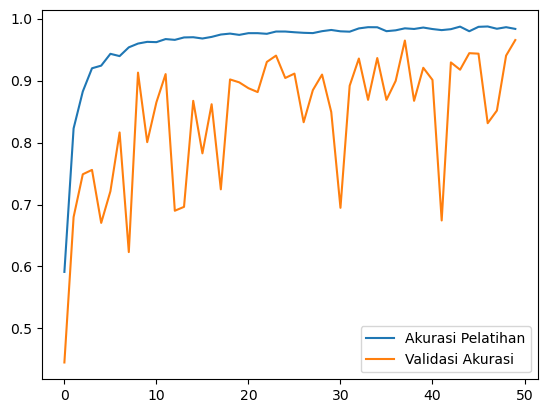

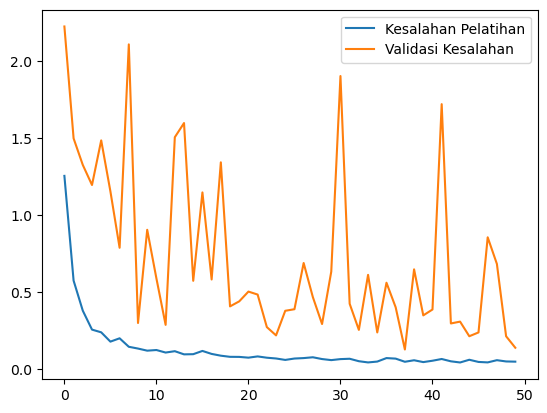

In [33]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

## Evaluation

In [34]:
!ls

DeteksiPenyakitTanaman.hdf5  tomato


In [35]:
#load the model weight file with lowest validation loss
model.load_weights("DeteksiPenyakitTanaman.hdf5")

In [36]:
#check the model metrics
print(model.metrics_names)
#evaluate training data
print(model.evaluate(x= x_train, y = y_train))
#evaluate  validation data
print(model.evaluate(x= x_valid, y = y_valid))
#evaluate  test data
print(model.evaluate(x= x_test, y = y_test))

['loss', 'acc']
275/275 [==============================] - 3s 9ms/step - loss: 0.0900 - acc: 0.9705
[0.08995316922664642, 0.9704545736312866]
42/42 [==============================] - 1s 14ms/step - loss: 0.1285 - acc: 0.9636
[0.1284816712141037, 0.9636363387107849]
28/28 [==============================] - 0s 9ms/step - loss: 0.1390 - acc: 0.9557
[0.13901475071907043, 0.9556818008422852]


In [37]:
#draw a confusion matrix

#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

28/28 [==============================] - 0s 7ms/step
[0 0 8 0 3 9 0 4 0 9 6 6 3 8 0 4 6 6 1 5 0 5 2 1 4 8 6 7 6 4 6 6 7 4 4 8 1
 9 9 9 9 9 6 0 3 4 5 1 8 5 4 8 7 7 0 0 5 0 3 9 3 6 0 9 5 9 5 9 9 5 2 4 0 2
 1 9 1 7 7 8 2 5 3 2 3 1 9 0 5 0 3 3 1 1 2 3 7 2 6 3 7 8 4 2 0 4 8 1 5 4 2
 5 3 8 9 1 7 2 7 8 4 4 1 0 2 7 7 4 3 8 3 3 5 1 5 3 1 0 7 5 0 3 2 6 7 5 4 8
 0 3 3 4 6 8 0 9 7 0 7 7 3 1 4 2 0 3 7 9 0 6 0 6 6 3 8 0 9 6 4 8 8 0 1 3 2
 0 4 5 8 2 0 2 9 5 5 8 1 3 3 8 5 5 4 2 2 4 1 7 8 1 6 5 9 3 1 7 9 9 8 8 6 0
 5 6 0 6 5 4 7 0 6 8 8 2 1 4 0 2 2 8 6 9 0 1 0 3 5 0 7 9 4 9 7 2 7 0 5 8 6
 4 8 4 0 5 2 6 6 7 6 9 8 2 0 9 2 4 5 9 9 1 0 7 5 6 3 1 0 1 5 1 5 5 9 5 6 2
 8 2 1 4 0 5 4 0 7 3 8 2 3 2 0 6 1 1 6 3 2 3 0 5 6 3 7 4 8 2 5 1 8 1 5 4 2
 7 3 6 8 8 7 8 3 5 0 4 4 3 0 2 2 4 0 8 1 1 7 2 2 9 6 2 0 3 7 9 8 4 0 9 6 7
 8 3 4 0 2 4 7 4 9 9 9 4 8 1 4 2 2 9 6 2 8 4 0 8 5 3 3 3 2 7 8 5 3 4 3 2 6
 6 3 7 0 6 9 0 7 3 4 6 6 9 8 1 7 1 3 8 7 8 5 3 7 2 9 8 1 7 5 2 6 7 8 4 2 8
 4 3 4 8 0 2 5 8 0 5 0 7 9 0 1 0 5 6 7 6 2 5 1 

Normalized confusion matrix
[[0.95 0.01 0.   0.   0.   0.   0.01 0.02 0.   0.  ]
 [0.01 0.92 0.   0.   0.   0.   0.   0.07 0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.97 0.   0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.   0.   0.   0.99 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.93 0.05]
 [0.02 0.   0.07 0.   0.1  0.   0.   0.01 0.   0.8 ]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

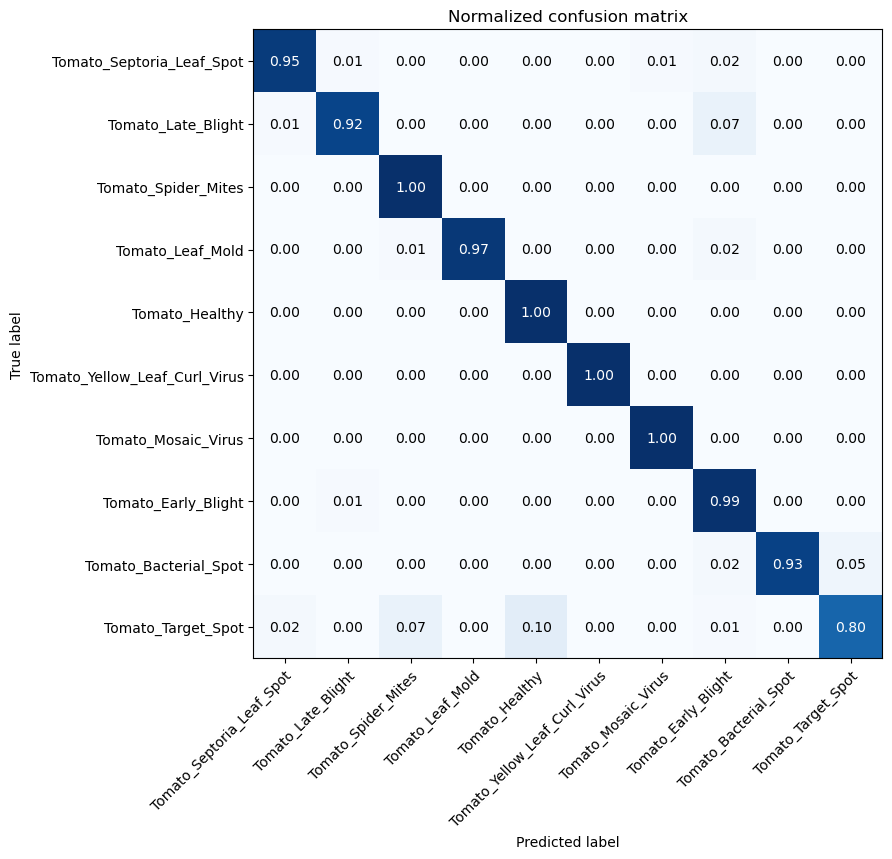

In [38]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')



## Predicting Indivisual Images

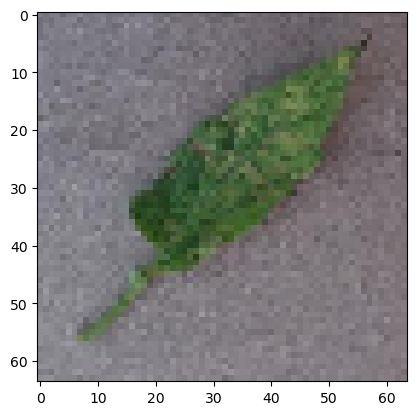

Gambar Yang Benar Adalah: 3 : Tomato_Leaf_Mold
1/1 [==============================] - 0s 23ms/step
prediksi Value: [1.31e-05 4.59e-06 4.09e-07 1.00e+00 1.10e-09 5.08e-08 2.28e-05 2.35e-07
 6.07e-12 8.30e-07]
prediksi gambar: 3 : Tomato_Leaf_Mold
Prediksi Benar


In [39]:
n = 99 #do not exceed (number of test image - 1)

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test,axis=1)[n]
print("Gambar Yang Benar Adalah:",true_label,":",class_names[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("prediksi Value:",prediction)
predicted_label = np.argmax(prediction)
print("prediksi gambar:",predicted_label,":",class_names[predicted_label])

if true_label == predicted_label:
    print("Prediksi Benar")
else:
    print("Prediksi Salah")

In [40]:
keras_file = "DeteksiPenyakitTanaman.hdf5"
tf.keras.models.save_model(model, keras_file)

In [48]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError
import io

# Informasi terkait Cloud Object Storage
cos_credentials = {
    "apikey": "8QCKzP-9qx9M56B73EYM8RbsTy6ZewdwmUR4sV74be0I",
    "cos_hmac_keys": {
        "access_key_id": "277d348a12a8495682087b948a04d40c",
        "secret_access_key": "666c2d665d62deecd4532cf7676eef1c63d278a64bf14f0b"
    },
    "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
    "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/c61986905f3542b7bce9b5831d2529ec:7198d0af-f4bf-4473-9e7a-35353cd1e124:resource-key:277d348a-12a8-4956-8208-7b948a04d40c",
    "iam_apikey_name": "WDP-Editor-tomatodisease-donotdelete-pr-eyuhd6422fphom",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/c61986905f3542b7bce9b5831d2529ec::serviceid:ServiceId-d32363dc-3b26-4f06-a872-7ba5674b34b3",
    "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/c61986905f3542b7bce9b5831d2529ec:7198d0af-f4bf-4473-9e7a-35353cd1e124::"
}
auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

In [49]:
# Buat client
cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

In [50]:
# Fungsi untuk upload file ke Cloud Object Storage
def upload_file(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = os.path.basename(file_name)
    s3_client = cos
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [51]:
# Upload file model ke Cloud Object Storage
upload_file('./DeteksiPenyakitTanaman.hdf5','tomatodisease-donotdelete-pr-eyuhd6422fphom')

True